In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab
import math
import datetime
import yfinance as yf
from pathlib import Path
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from pandas_datareader import data as web
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import kstest_normal

### Functions

In [9]:
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test == 'kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {
        'Test Statistic': test_score, 
        'p-value': pval,
        'Numbers of lags': lags, 
        'decision': decision
    }

    for key, value in critical.items():
        output_dict['Critical Value (%s)' % key] = value

    return pd.Series(output_dict, name=test)

In [11]:
# adf_output = adfuller(dt.AAPL)
# kpss_output = kpss(dt.AAPL)

In [13]:
# pd.concat([print_results(adf_output, 'adf'), print_results(kpss_output, 'kpss')], axis=1)

In [289]:
# outlier identifier function
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])  # Calculate the 25th and 75th percentiles
    IQR = q3 - q1  # Interquartile range
    lower_fence = q1 - (1.5 * IQR)  # Lower bound for outliers
    upper_fence = q3 + (1.5 * IQR)  # Upper bound for outliers
    return data[(data > upper_fence) | (data < lower_fence)] 

In [23]:
# outliers = iqr_outliers(dt)
# outliers

In [297]:
# z score function
def zscore(df, column_name, degree=3):
    data = df.copy()
    data['zscore'] = (data[column_name] - data[column_name].mean()) / data[column_name].std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    return outliers[column_name], data

In [27]:
# threshold = 2.5
# outliers, transformed = zscore(dt, 'AAPL', threshold)

In [31]:
# transformed[['AAPL', 'zscore']].hist()

In [33]:
# plot zscore
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(10, 6))
    plt.plot(data, 'k^')
    plt.plot([0, n], [d, d], 'r--')
    plt.plot([0, n], [-d, -d], 'r--')

In [35]:
# data = transformed['zscore'].values
# plot_zscore(data, d=2.5)

In [25]:
# normal distribution
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print('Reject null hypothesis. Data is not normally distributed')
    else:
        print('Fail to reject null hypothesis. Data is normally distributed')

In [19]:
# test_normal(dt.AAPL)

### Data Handling

In [40]:
file_path = Path('data/Weather_Data.csv')

In [44]:
df = pd.read_csv(file_path, sep=',', parse_dates = ['Date'], index_col = 'Date')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38355 entries, 2000-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           38355 non-null  object 
 1   Country        38355 non-null  object 
 2   Temperature    38355 non-null  float64
 3   Humidity       38355 non-null  float64
 4   Wind Speed     38355 non-null  float64
 5   Precipitation  38355 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.0+ MB


In [105]:
print(df.index)

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=38355, freq=None)


In [57]:
df.shape

(38355, 6)

In [59]:
df.isnull().sum()

City             0
Country          0
Temperature      0
Humidity         0
Wind Speed       0
Precipitation    0
dtype: int64

In [61]:
df.isna().sum()

City             0
Country          0
Temperature      0
Humidity         0
Wind Speed       0
Precipitation    0
dtype: int64

In [63]:
df.isna().sum().sum()

0

In [69]:
df.describe(include='all')

,City,Country,Temperature,Humidity,Wind Speed,Precipitation
count,38355,38355,38355.000000,38355.000000,38355.000000,38355.000000
unique,5,5,NaN,NaN,NaN,NaN
top,New York,USA,NaN,NaN,NaN,NaN
freq,7671,7671,NaN,NaN,NaN,NaN
mean,NaN,NaN,14.967488,60.083802,14.988374,10.038591
std,NaN,NaN,14.397666,17.313704,8.633390,5.788679
min,NaN,NaN,-9.999842,30.000217,0.001064,0.000172
25%,NaN,NaN,2.525902,45.057278,7.556796,4.987680
50%,NaN,NaN,15.136597,60.031962,14.947117,10.080872
75%,NaN,NaN,27.416420,75.059592,22.420389,15.070801


In [71]:
df.City.value_counts()

City
New York    7671
London      7671
Tokyo       7671
Sydney      7671
Paris       7671
Name: count, dtype: int64

In [73]:
df.Country.value_counts()

Country
USA          7671
UK           7671
Japan        7671
Australia    7671
France       7671
Name: count, dtype: int64

In [77]:
df.memory_usage(deep=True)

Index             306840
City             2109525
Country          2071170
Temperature       306840
Humidity          306840
Wind Speed        306840
Precipitation     306840
dtype: int64

In [79]:
df.City = df.City.astype('category')
df.Country = df.City.astype('category')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38355 entries, 2000-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   City           38355 non-null  category
 1   Country        38355 non-null  category
 2   Temperature    38355 non-null  float64 
 3   Humidity       38355 non-null  float64 
 4   Wind Speed     38355 non-null  float64 
 5   Precipitation  38355 non-null  float64 
dtypes: category(2), float64(4)
memory usage: 1.5 MB


In [83]:
df.memory_usage(deep=True)

Index            306840
City              38802
Country           38802
Temperature      306840
Humidity         306840
Wind Speed       306840
Precipitation    306840
dtype: int64

<Axes: xlabel='Date'>

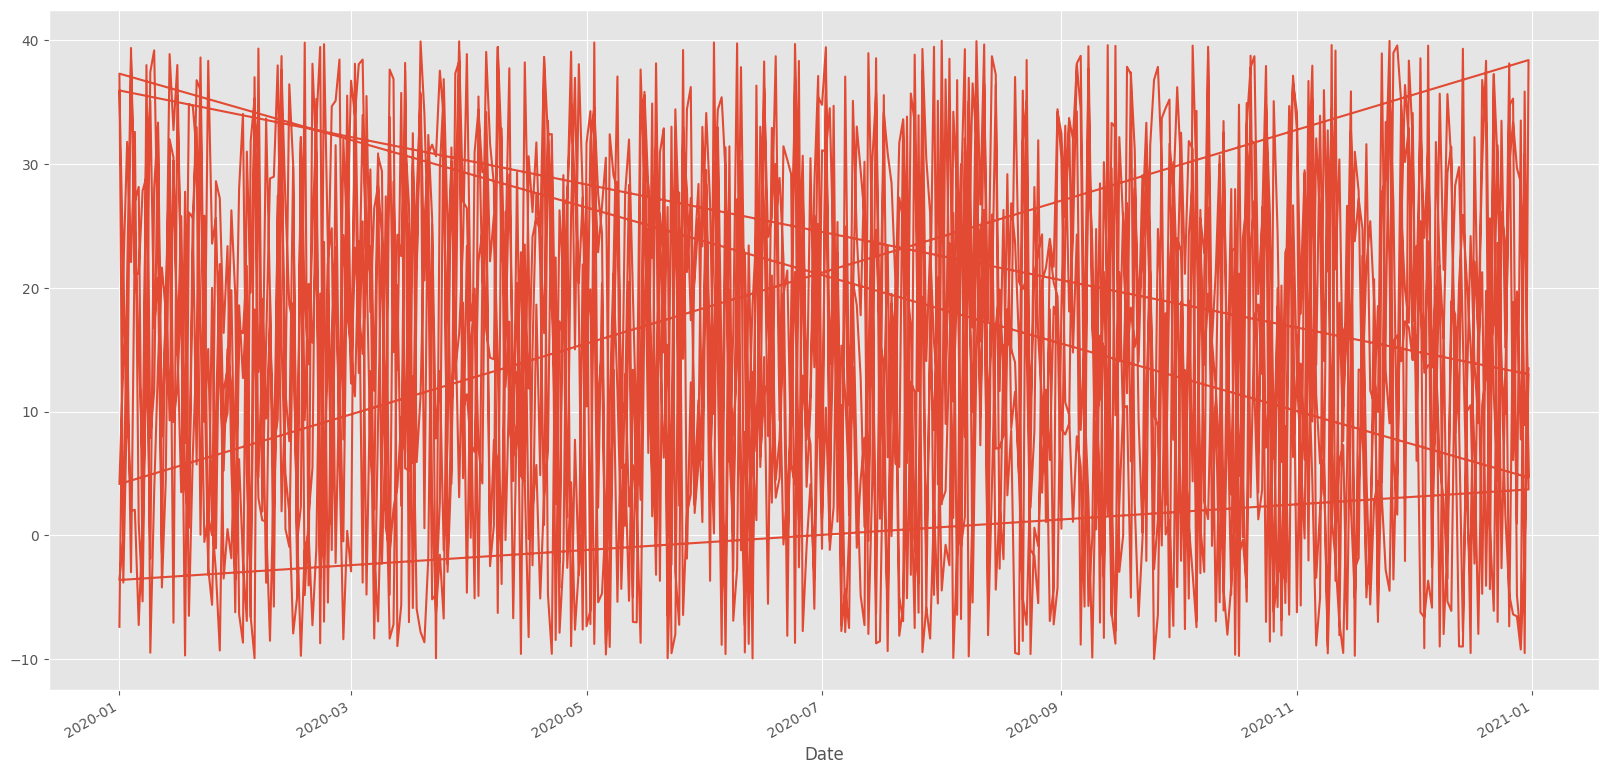

In [135]:
plt.style.use('ggplot')
df.Temperature.loc['2020-1':].plot(figsize=(20, 10))

In [139]:
df.shape

(38355, 6)

In [151]:
# dataframe with only numerical columns
df_numeric = df.copy()

In [155]:
del df_numeric['City']
del df_numeric['Country']

In [157]:
df_weekly = df_numeric.resample('2W').mean()

In [159]:
df_weekly.shape

(549, 4)

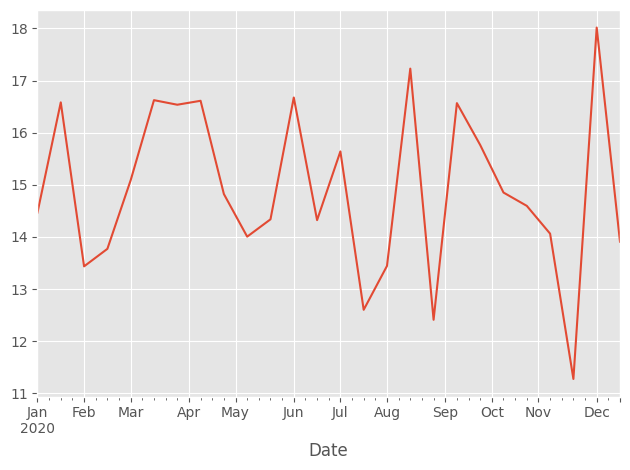

In [167]:
df_weekly.Temperature.loc['2020'].plot(); plt.tight_layout()

In [169]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 549 entries, 2000-01-02 to 2021-01-03
Freq: 2W-SUN
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    549 non-null    float64
 1   Humidity       549 non-null    float64
 2   Wind Speed     549 non-null    float64
 3   Precipitation  549 non-null    float64
dtypes: float64(4)
memory usage: 21.4 KB


In [171]:
df_weekly.index.freq

<2 * Weeks: weekday=6>

In [173]:
df_weekly.head()

,Temperature,Humidity,Wind Speed,Precipitation
Date,,,,
2000-01-02,14.963456,55.621232,15.818211,10.186763
2000-01-16,16.689333,62.823386,17.389331,9.978106
2000-01-30,16.631453,61.178831,14.231483,10.517628
2000-02-13,14.381301,59.741390,15.894905,10.025463
2000-02-27,15.166832,61.186037,14.002758,9.826471


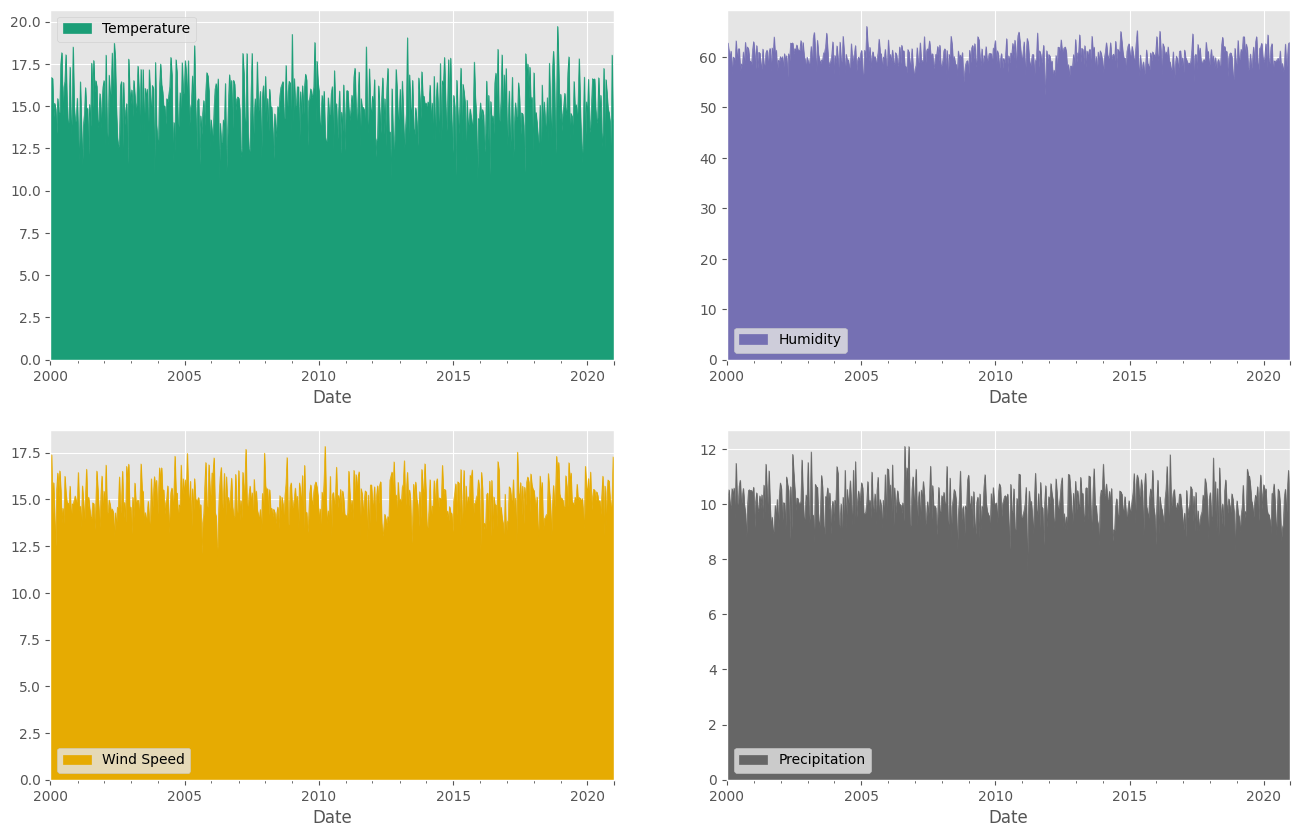

In [191]:
df_weekly.plot.area(
    subplots = True, 
    colormap = 'Dark2', 
    linewidth = 0.5,
    layout = (2, 2), 
    figsize = (16, 10), 
    sharex = False, 
    sharey = False
); plt.show()

In [208]:
df_sample = df_weekly.loc['2015':].copy()

In [210]:
df_sample.head()

,Temperature,Humidity,Wind Speed,Precipitation
Date,,,,
2015-01-11,15.630487,60.498491,14.900590,9.653189
2015-01-25,14.983610,60.085178,15.326549,9.836597
2015-02-08,10.864697,62.110722,15.831788,10.140069
2015-02-22,16.526211,60.703054,14.115821,10.427850
2015-03-08,14.568218,58.821073,15.943572,11.103881


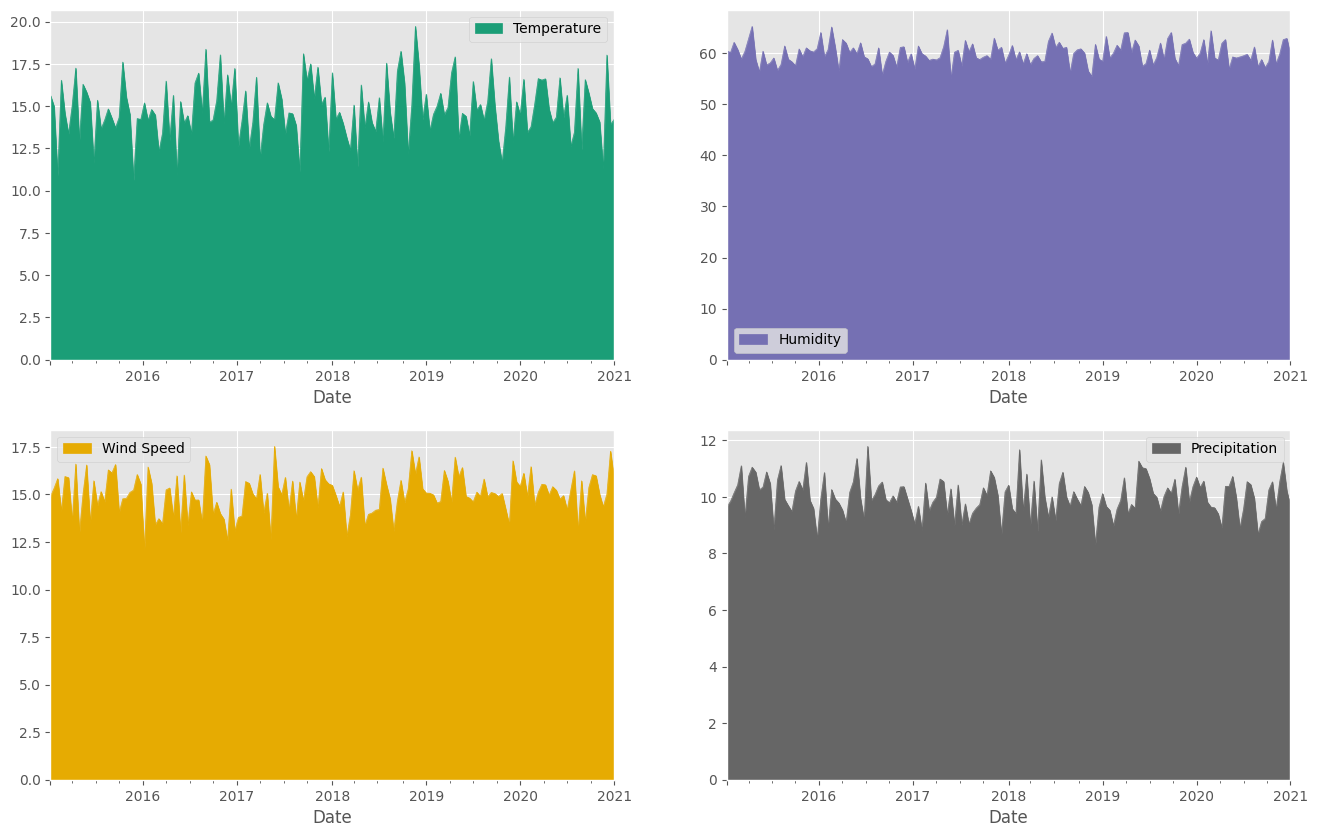

In [212]:
df_sample.plot.area(
    subplots = True, 
    colormap = 'Dark2', 
    linewidth = 0.5,
    layout = (2, 2), 
    figsize = (16, 10), 
    sharex = False, 
    sharey = False
); plt.show()

In [214]:
df_sample.shape

(157, 4)

### Outlier Detection

<Axes: xlabel='Date'>

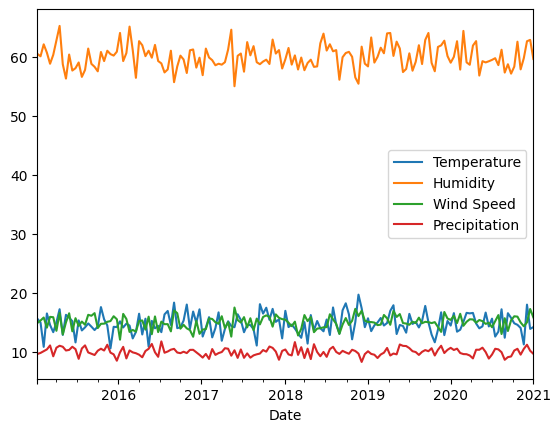

In [225]:
plt.style.use('default')
df_sample.plot(alpha=1.0)

<Axes: xlabel='Temperature', ylabel='Count'>

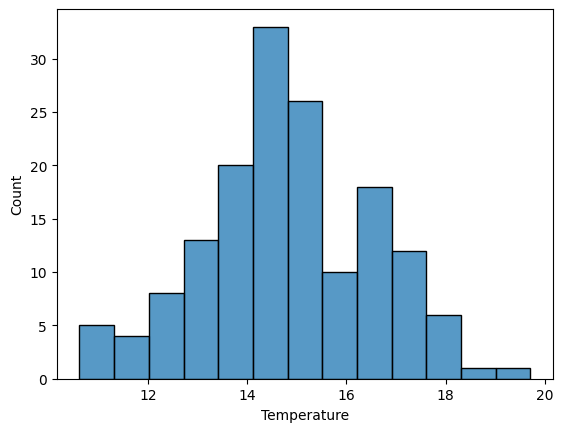

In [227]:
sns.histplot(df_sample.Temperature)

In [247]:
# for i in [df_sample.Humidity, df_sample['Wind Speed'], df_sample['Precipitation']]:
#     sns.histplot(i)
#     plt.show()

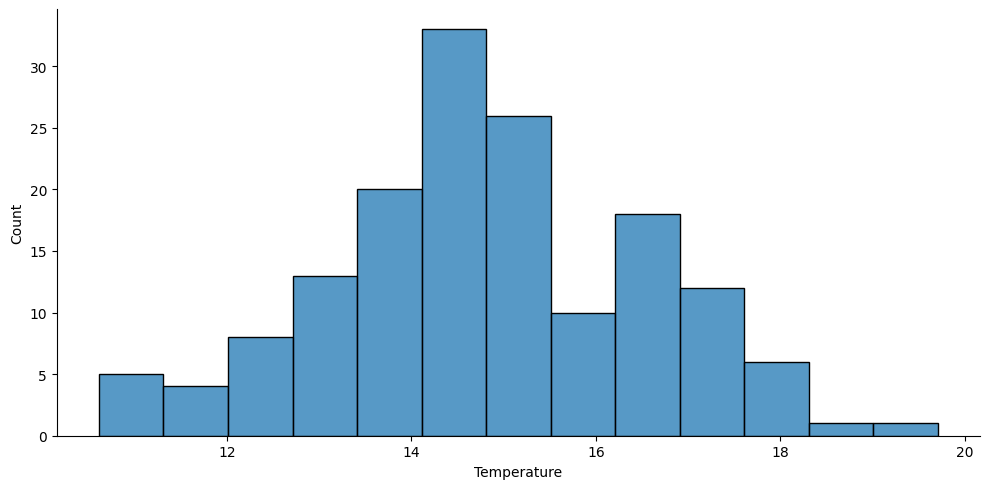

In [257]:
sns.displot(df_sample.Temperature, kind='hist', aspect=2)

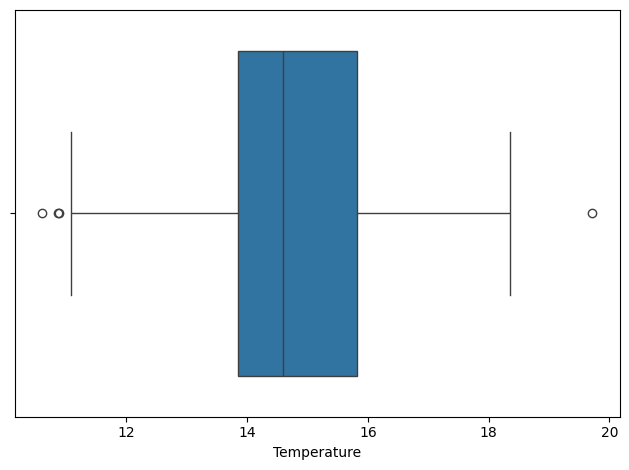

In [271]:
sns.boxplot(df_sample.Temperature, orient='h', whis=1.5); plt.tight_layout()

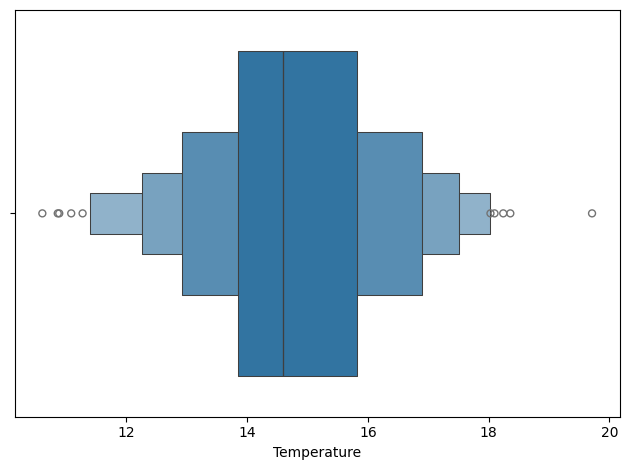

In [275]:
sns.boxenplot(df_sample.Temperature, orient='h'); plt.tight_layout()

<Axes: xlabel='Temperature'>

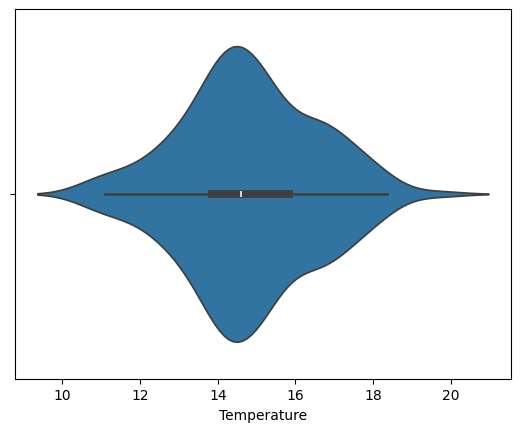

In [279]:
sns.violinplot(df_sample.Temperature, orient='h')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

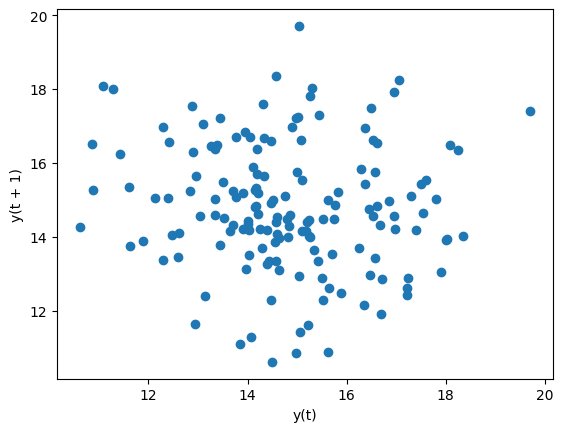

In [281]:
lag_plot(df_sample.Temperature)

In [283]:
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
df_sample.Temperature.describe(percentiles= percentiles)

count    157.000000
mean      14.798228
std        1.721412
min       10.609655
0%        10.609655
5%        11.842976
10%       12.607547
25%       13.856597
50%       14.596156
75%       15.824808
90%       17.122158
95%       17.641703
100%      19.711960
max       19.711960
Name: Temperature, dtype: float64

In [293]:
outliers = iqr_outliers(df_sample.Temperature)
outliers

Date
2015-02-08    10.864697
2015-11-29    10.609655
2016-05-15    10.889565
2018-11-25    19.711960
Name: Temperature, dtype: float64

In [309]:
threshold = 2
outliers, transformed = zscore(df_sample, 'Temperature', threshold)

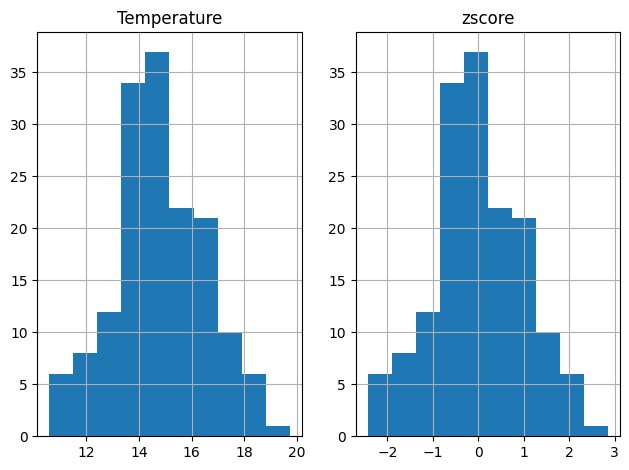

In [311]:
transformed[['Temperature', 'zscore']].hist(); plt.tight_layout()

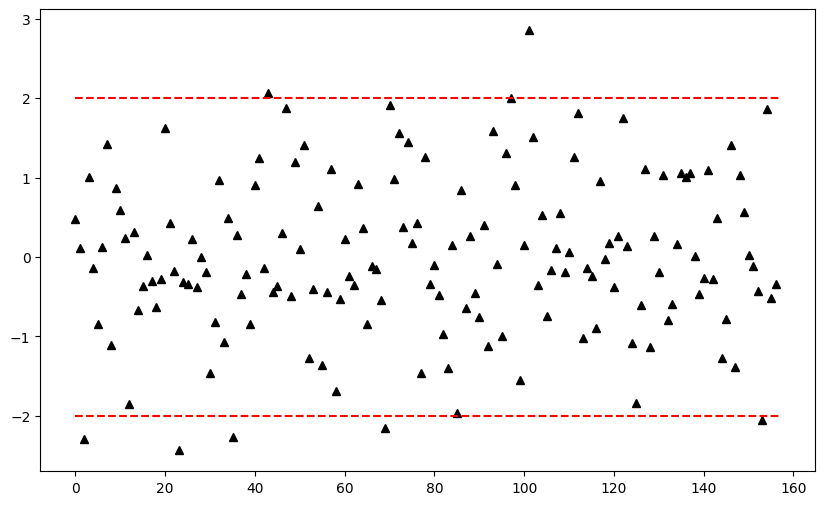

In [317]:
data = transformed['zscore'].values
plot_zscore(data, d=2)

In [321]:
test_normal(df_sample.Temperature)

Fail to reject null hypothesis. Data is normally distributed


<Axes: xlabel='Temperature', ylabel='Density'>

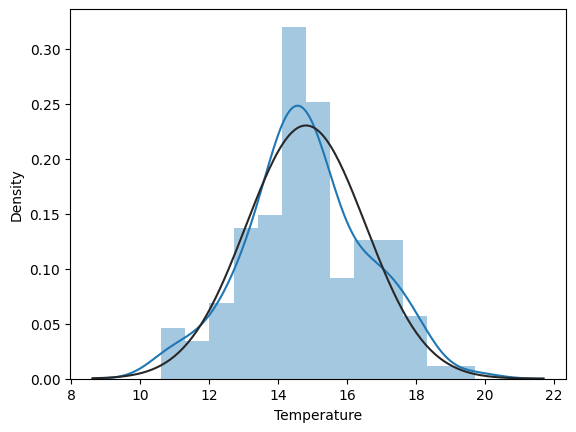

In [395]:
from numpy.random import normal, seed
from scipy.stats import norm
sns.distplot(df_train.Temperature, fit=norm, kde=True)

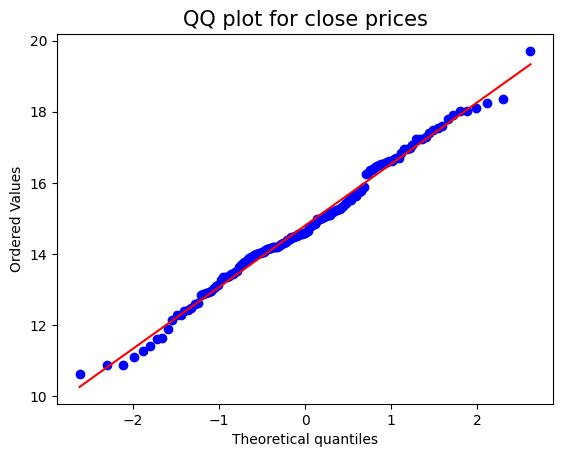

In [373]:
scipy.stats.probplot(df_sample.Temperature, plot = pylab)
plt.title('QQ plot for close prices', size=15)
plt.show()

In [323]:
print(outliers)

Date
2015-02-08    10.864697
2015-11-29    10.609655
2016-05-15    10.889565
2016-09-04    18.358716
2017-09-03    11.087666
2018-09-30    18.241484
2018-11-25    19.711960
2020-11-22    11.276116
Name: Temperature, dtype: float64


### Train & Test

In [348]:
size = int(len(df_sample) * 0.8)

In [350]:
df_train = df_sample.iloc[:size]
df_test = df_sample.iloc[size:]

In [352]:
df_train.tail(2)

,Temperature,Humidity,Wind Speed,Precipitation
Date,,,,
2019-09-29,15.030452,64.033985,15.048757,10.125065
2019-10-13,12.943136,58.970684,14.889666,10.626935


In [354]:
df_test.head(2)

,Temperature,Humidity,Wind Speed,Precipitation
Date,,,,
2019-10-27,11.636654,57.546950,15.051086,9.400160
2019-11-10,13.763266,61.666528,14.236406,10.367781


In [366]:
df_test.tail(1)

,Temperature,Humidity,Wind Speed,Precipitation
Date,,,,
2021-01-03,14.208736,59.634371,15.85893,9.688337


In [362]:
start_date = '2019-10-27'
end_date = '2021-01-03'

In [387]:
import warnings
warnings.filterwarnings('ignore')

In [375]:
adfuller(df_train.Temperature)

(-11.910461888622327,
 5.311695583776697e-22,
 0,
 124,
 {'1%': -3.484219653271961,
  '5%': -2.885145235641637,
  '10%': -2.579359138917794},
 439.9328104903653)

In [389]:
adf_output = adfuller(df_train.Temperature)
kpss_output = kpss(df_train.Temperature)

In [391]:
pd.concat([print_results(adf_output, 'adf'), print_results(kpss_output, 'kpss')], axis=1)

,adf,kpss
Test Statistic,-11.910462,0.264322
p-value,0.0,0.1
Numbers of lags,0,2
decision,Stationary,Stationary
Critical Value (1%),-3.48422,0.739
Critical Value (5%),-2.885145,0.463
Critical Value (10%),-2.579359,0.347
Critical Value (2.5%),NaN,0.574


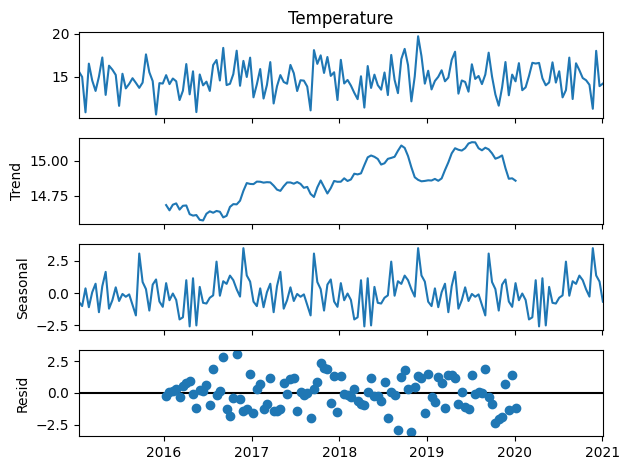

In [405]:
seasonal_additive = seasonal_decompose(df_sample.Temperature, model = 'additive')
seasonal_additive.plot()
plt.show()

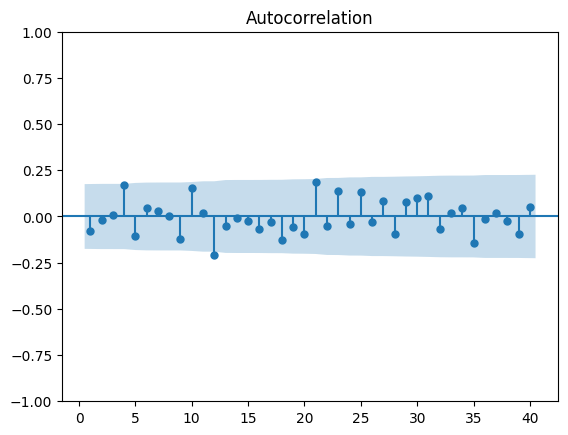

In [398]:
sgt.plot_acf(df_train.Temperature, lags = 40, zero = False)
plt.show()

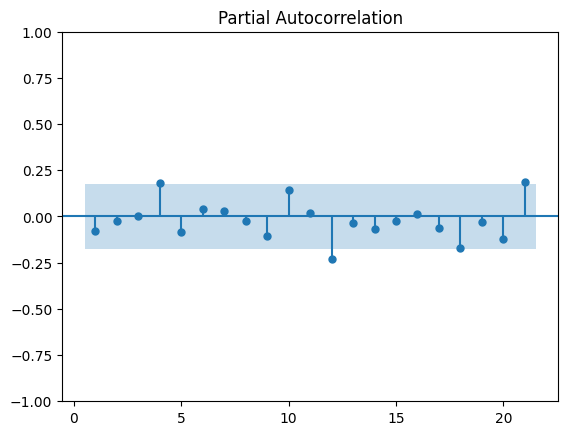

In [400]:
sgt.plot_pacf(df_train.Temperature, zero = False, method = ('ols'))
plt.show()

In [407]:
import pmdarima as pm

In [409]:
results1 = pm.auto_arima(df_sample.Temperature)
print(results1)

 ARIMA(0,0,0)(0,0,0)[0] intercept


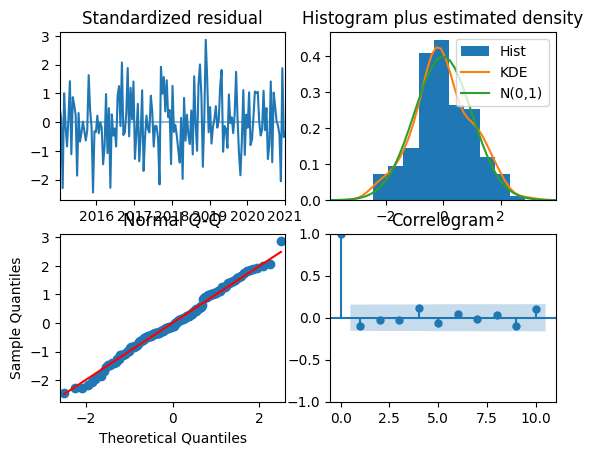

In [415]:
results1.plot_diagnostics(); plt.show()

In [419]:
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  157
Model:                        SARIMAX   Log Likelihood                -307.545
Date:                Sat, 29 Mar 2025   AIC                            619.091
Time:                        15:33:57   BIC                            625.203
Sample:                    01-11-2015   HQIC                           621.573
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.7982      0.137    108.012      0.000      14.530      15.067
sigma2         2.9444      0.340      8.655      0.000       2.278       3.611
Ljung-Box (L1) (Q):                   1.53   Jarque-